<a href="https://colab.research.google.com/github/marcinwolter/TrackingGNN_2023/blob/main/GNN_muonE_false_hits_MW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

Adapted for MuonE tracking by Marcin Wolter

*July 2020*

In [1]:
!pip uninstall torchvision torchtext torchaudio --yes
!pip install torch==1.11.0+cu113  -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [3]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

1.11.0+cu113
PyTorch version: None , CUDA version: 11.3


In [4]:
#!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
"""
!pip install torch-geometric
!pip install torch-sparse
!pip install torch-scatter"""
# MW corrected

!pip install torch-geometric \
  torch-sparse==0.6.13 \
  torch-scatter==2.0.9 \
  -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


In [5]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [6]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""

    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers

    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())

    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True,normalize_factor= 1):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)
        self.normalize_factor=normalize_factor
    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)
        
        # Encode the graph features into the hidden space
        #print( torch.mean (data.x[:,0]) )
        #print( torch.mean (data.x[:,1]) )
        if self.normalize_factor!=1:
          temp = data.x.clone().detach()
          temp[:,1] *= self.normalize_factor
          x = self.node_encoder(temp)
        else:
          x = self.node_encoder(data.x.clone().detach())
        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

### Training

In [7]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [8]:
!git clone https://github.com/kamileo96/GNN-Tracking.git
path = '/content/GNN-Tracking/data/'
#Only small and medium files!

fatal: destination path 'GNN-Tracking' already exists and is not an empty directory.


In [9]:
gdrive=False
if gdrive:
  from google.colab import drive
  drive.mount('/content/drive/')
  path = '/content/drive/My Drive/MuonE_tracking/'

In [10]:
import numpy as np, pandas as pd
from torch_geometric.data import Data
from torch_geometric.data import DataLoader



#this is what we multiply all inputs by
feature_scale = 1/200
#this is the expected z/x or z/y ratio, that we need to correct when running the GNN
norm_factor = 2000
#                         z scale, x or y scale
feature_scaling = np.array([feature_scale, feature_scale*norm_factor])

#so now our inputs (data.x) should be roughly the same magintudes
#thus the normalize_factor option in the GNN will be set to 1
#we will use the feature scaling again when comparing with real data, this should provide a better 3D line fit

def gen_edges(new_df):
  df = new_df.groupby('layerIndex')
  group_names = list(df.groups.keys())
  # iterate over two consecutive layers
  edges = []
  y = []
  for i in range(len(group_names) - 1):
    layer1 = df.get_group(group_names[i])
    layer2 = df.get_group(group_names[i + 1])
    for _, hit1 in layer1.iterrows():
      for _, hit2 in layer2.iterrows():
        edges.append([hit1.newIndex, hit2.newIndex])

        #this assumes only 1 particle of each ID
        #edgeTruthValue=True only for edges connecting the hits from the same track. The track should be 0,1 or 2
        #MWMW edgeTruthValue if hit1.trackID == hit2.trackI and hit1.trackID in 0,1,2 and hit2.trackID in 0,1,2
        if hit1.trackID in [0,1,2] and hit2.trackID in [0,1,2]:
          edgeTruthValue = hit1.trackID == hit2.trackID #or (hit1.trackID == 0 and hit2.trackID in [1, 2]) #to connect 0 with 1 and 2 (bad idea)
        else:
          edgeTruthValue = False

        #option to classify edges between hits other than 0, 1, 2
        classifyNoise = True
        if not classifyNoise and edgeTruthValue:
          edgeTruthValue = hit1.trackID in [0, 1, 2]
        y.append(int(edgeTruthValue))
  return np.transpose(edges).astype(int), y

#MWMW I don't use it. Maybe better, but I had no time to study it
def gen_edges_faster(df):
  #by chatGPT :)
  #this returns edges in format [[from][to]] and y
  # Group the dataframe by layerIndex
  groups = df.groupby('layerIndex')
  
  # Extract the indices and track IDs of each group
  indices = [group['newIndex'].values for _, group in groups]
  track_ids = [group['trackID'].values for _, group in groups]

  # Get the number of groups
  n_groups = len(groups)

  # Create an array to hold the edges
  n_edges = sum(len(indices[i]) * len(indices[i+1]) for i in range(n_groups - 1))
  edges = np.empty((2, n_edges), dtype=int)

  # Create an array to hold the matches
  #this will be the y vector
  matches = np.zeros(n_edges, dtype=int)

  # Loop over each pair of adjacent layers
  edge_index = 0
  for i in range(n_groups - 1):
    # Get the indices and track IDs of the two layers
    layer1_indices, layer2_indices = indices[i], indices[i+1]
    layer1_track_ids, layer2_track_ids = track_ids[i], track_ids[i+1]

    # Generate the edges between the two layers
    
    layer1_indices_repeated = np.repeat(layer1_indices, len(layer2_indices))
    layer2_indices_tiled = np.tile(layer2_indices, (len(layer1_indices)))
    edges[:, edge_index:edge_index + len(layer1_indices) * len(layer2_indices)] = np.stack([layer1_indices_repeated, layer2_indices_tiled])
    
    #calculate y
    layer1_trackID_repeated = np.repeat(layer1_track_ids, len(layer2_indices))
    layer2_trackID_tiled = np.tile(layer2_track_ids, (len(layer1_indices)))
    matches_slice = layer1_trackID_repeated == layer2_trackID_tiled
    matches[edge_index:edge_index + len(layer1_indices) * len(layer2_indices)] = matches_slice.flatten()


    # Update the edge index
    edge_index += len(layer1_indices) * len(layer2_indices)

  #shuffle the edges
  shuffle = True
  if shuffle:
    neidx = np.arange(n_edges)
    np.random.shuffle(neidx)
    edges[0] = edges[0][neidx]
    edges[1] = edges[1][neidx]
    matches = matches[neidx]
  return edges, matches


def gen2D_event_data(event):
  neidx = np.arange(len(event))
  #np.random.shuffle(neidx)
  new_df = event.copy()
  new_df['newIndex'] = neidx
  new_df = new_df.sort_values('newIndex')

  #MWMW using old, slow gen_edges
  #MWMW edge_index, y = gen_edges_faster(new_df)
  edge_index, y = gen_edges(new_df)

  x = new_df[['layerZ', 'hitPos']].values * feature_scaling
  #edge_index = np.transpose(edges).astype(int)
  y = np.array(y)

  #for debug:
  nev = event.iloc[0,0]
  #combining into Data:
  event_data = Data(x = torch.from_numpy(x).float(), edge_index = torch.from_numpy(edge_index), y = torch.from_numpy(y), nevent = nev)
  return event_data

def LoadHitFile(event_file):
  
  data = pd.read_csv(event_file)
  data.rename(columns=lambda x: x.strip(), inplace=True)

  #option to remove praticles with ID other than 0,1,2 from dataset
  removeNoise = False
  if removeNoise:
    data = data[data['trackID'].isin([0, 1, 2])]
  #tensors with x as points, edge_index as edges, y as edges values and nevent to track nEvent after shuffling (debug)
  event_data_list_x = []
  event_data_list_y = []
  #lists of small data frames containing full information from hit types 2 , 3 for each nEvent
  stereo2_list = []
  stereo3_list = []
  for num, event in data.groupby(data['nEvent']):
    grouped_data = event.groupby('hitType')
    group_names = list(grouped_data.groups.keys())
    eventx = grouped_data.get_group(0)
    eventy = grouped_data.get_group(1)
    stereo2 = grouped_data.get_group(2)
    stereo3 = grouped_data.get_group(3)
    temp = []
    try:
      temp.append(gen2D_event_data(eventx))
      temp.append(gen2D_event_data(eventy))
      temp.append(stereo2)
      temp.append(stereo3)
      #this prevents adding an event that could be generated in X but not in Y, or reverse
      event_data_list_x.append(temp[0])
      event_data_list_y.append(temp[1])
      stereo2_list.append(temp[2])
      stereo3_list.append(temp[3])
    except Exception as e:
      print(f'Event number {num} unusable.')
      print(e)
      pass
  
  return event_data_list_x, event_data_list_y, stereo2_list, stereo3_list

def LoadReconFile(event_file,num_events):
  #returns list num events long
  #each element is a 2 by 11 array, where value 11 is Ax^2+Ay^2, added to predict which one is the muon
  data = pd.read_csv(event_file)
  data.rename(columns=lambda x: x.strip(), inplace=True)
  data['Asq'] = data['Ax']**2 + data['Ay']**2
  

  #this fills the not-reconstructed events with either zeros or empty arrays
  events = data.groupby('nEvent')
  #num_events = len(events) #this doesnt work because this must have the same len as the hitfile
  event_list = [np.zeros((2, data.shape[1])) for i in range(num_events)] #this could be zeros((0,...))
  
  #this should work even if some nevents are missing
  for i, [idx, group] in enumerate(events):
    event_list[idx-1] = group.sort_values('Asq', ascending=True).to_numpy()
  return event_list

def LoadMCFile(event_file,num_events):
  #returns list num events long
  #each element is a 2 by 6 array: [[nevent, x0, y0, Ax, Ay, trackid] (muon),[...](electron)]
  #Az=1
  data = pd.read_csv(event_file)
  data.rename(columns=lambda x: x.strip(), inplace=True)

  data = data[data['trackID'].isin([1, 2])]
  data['Ax'] = data['px']/data['pz']
  data['Ay'] = data['py']/data['pz']

  data['t'] = (0-data['z'])/data['pz']
  data['x0'] = data['x'] + data['px']*data['t']
  data['y0'] = data['y'] + data['py']*data['t']

  data2 = data[['nEvent', 'x0', 'y0', 'Ax', 'Ay', 'trackID']]
  
  #this fills the missing events with either zeros or empty arrays
  events = data2.groupby('nEvent')
  #num_events = len(events) #this doesnt work because this must have the same len as the hitfile
  event_list = [np.zeros((2, data2.shape[1])) for i in range(num_events)] #this could be zeros((0,...))
  
  for i, [idx , group] in enumerate(events):
    event_list[idx-1] = group.sort_values('trackID', ascending=True).to_numpy()
  return event_list

In [11]:
#from GNN_MuonE_v1_Robust_mc-recon_comparison.ipynb
#unused
#note - for now this loads all (would not work if some events are unusable)
def readMCtrack(event_file, is_x= True ):

  data = pd.read_csv(event_file) 

  if is_x:
    axis_oi=[4,1]
  else  :
    axis_oi=[5,2]

  temp=data.iat[-1,0]
  track_slopes=torch.zeros(temp,6)

  for k, row in data.iterrows():

    if (data.iat[k,7]==np.array([0,1,2])).any():

      

      if track_slopes.shape[0]< data.iat[k,0]-1 :
        track_slopes=torch.cat([track_slopes,torch.zeros(1,6)],dim=0)
      
      
      track_slopes[data.iat[k,0]-1,data.iat[k,7]*2 ] = data.iat[k,axis_oi[0]]/data.iat[k,6]

      track_slopes[data.iat[k,0]-1,data.iat[k,7]*2+1] =  data.iat[k,axis_oi[1]] - data.iat[k,axis_oi[0]]/data.iat[k,6]  * data.iat[k,3]
  
  return track_slopes










# Reads From Reconstruction File

def ReadRecon(event_file,is_x=True):
  data = pd.read_csv(event_file)  

  if is_x:
    axis_oi=[3,1,7,5,9]
  else:
    axis_oi=[4,2,8,6,9]

  track_=torch.zeros(data.iat[-1,0],10)

  for k,row in enumerate(data.iterrows()):

    if k % 2 ==0:
      #track_[data.iat[k,0]-1,0],track_[data.iat[k,0]-1,1]=data.iat[k,axis_oi[0]],data.iat[k,axis_oi[1]]
      for i in range( len(axis_oi) ):
        track_[data.iat[k,0]-1,i]=data.iat[k,axis_oi[i]]
    else:
      #track_[data.iat[k,0]-1 ,2],track_[data.iat[k,0]-1,3]=data.iat[k,axis_oi[0]],data.iat[k,axis_oi[1]]
      for i in range( len(axis_oi) ):
        track_[data.iat[k,0]-1,i+5]=data.iat[k,axis_oi[i]]
  

  temp=track_.clone()
  for i in range(data.iat[-1,0]):
    if torch.abs(temp[i,0])>torch.abs(temp[i,5]):

      track_[i,0:4]=temp[i,5:9]
      track_[i,5:9]=temp[i,0:4]



  return track_

In [12]:
def plot_toy_graph(event, ylim=0.):
    #print(event)
    #print(event.x)
    #print(event.edge_index)
    #print(event.y)
    
    # Now we mark true edges by red and the other by blue
    
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()[:,event.y==1]
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='r')
    e = event.edge_index.numpy()[:,event.y==0]
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
    if (ylim!=0):
       plt.ylim(-ylim,ylim)
    else:
       diff = 0.1*(max(y)-min(y))
       plt.ylim(min(y)-diff, max(y)+diff)   

In [13]:
#size = 'small'
size = 'medium'
filename = f'hitFile_{size}.csv'
filename_MC = f"MCtrackFile_{size}.csv"
filename_recon = f"trackFile_{size}.csv"
path = '/content/GNN-Tracking/data/'
#path = '/content/drive/My Drive/MuonE_tracking/'
event_file= path + filename
event_file_MC = path + filename_MC
event_file_recon = path + filename_recon

In [14]:
is_x = True
is_y = False


dataset_tuple = LoadHitFile(event_file)
num_events=len(dataset_tuple[0])
Tracks=LoadMCFile(event_file_MC, num_events)
Tracks_recon=LoadReconFile(event_file_recon, num_events)

In [15]:
from sklearn.model_selection import train_test_split


train_datasetx,test_datasetx, train_datasety,test_datasety, train_stereo2,test_stereo2,train_stereo3,test_stereo3,train_tracks,test_tracks,train_recon,test_recon = train_test_split(*dataset_tuple, Tracks, Tracks_recon,  test_size=0.2, random_state=42)

#here we define what to train and validate on
train_dataset = train_datasetx
test_dataset = test_datasetx
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


     nEvent        hitPos  hitType  layerZ  layerIndex  trackID
774      30  5.453560e-08        0   -21.0           1        0
776      30  1.479660e-03        0   151.0           3        0
778      30  7.048970e-03        0   497.0           5        0
781      30  7.681080e+00        0   843.7           7        2
782      30 -6.878740e-02        0   843.7           7        1
785      30  1.533060e+01        0  1141.0           9        2
786      30 -1.363250e-01        0  1141.0           9        1
789      30  1.862590e+01        0  1266.0          11        2
790      30 -1.647920e-01        0  1266.0          11        1
797      30  3.749470e+01        0  1960.0          15        2
798      30 -3.219850e-01        0  1960.0          15        1
tensor([[-1.0500e-01,  5.4536e-07],
        [ 7.5500e-01,  1.4797e-02],
        [ 2.4850e+00,  7.0490e-02],
        [ 4.2185e+00,  7.6811e+01],
        [ 4.2185e+00, -6.8787e-01],
        [ 5.7050e+00,  1.5331e+02],
        [ 5.7050

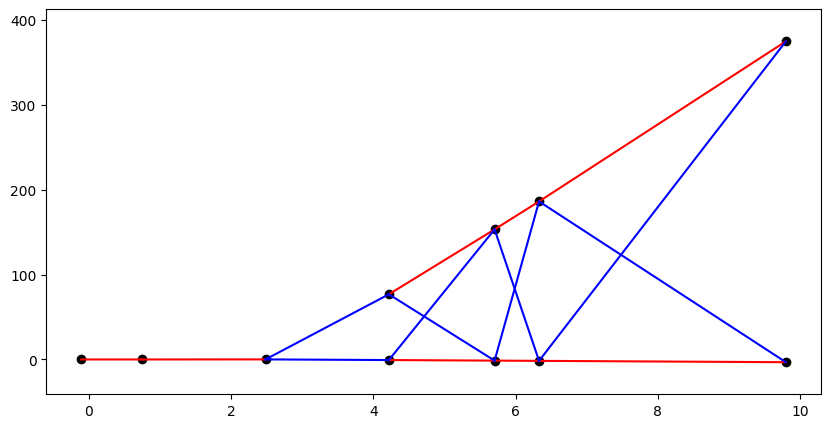

In [16]:
data = pd.read_csv(event_file)
data.rename(columns=lambda x: x.strip(), inplace=True)

data = data[data['hitType'] == 0]
#MWMW We do NOT remove noise
#MWMW removeNoise = True
removeNoise = False
if removeNoise:
  data = data[data['trackID'].isin([0, 1, 2])]
event = data[data['nEvent'] == 30]
print(event)
d = gen2D_event_data(event)
print(d.x,
d.edge_index,
d.y,
d.nevent)
plot_toy_graph(d, 0.)

18
11
11
11
11
11
12
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
tensor([[-1.0500e-01,  6.7764e-07],
        [ 7.5500e-01,  1.7708e-02],
        [ 2.4850e+00,  7.5396e-02],
        [ 4.2185e+00,  4.1147e+01],
        [ 4.2185e+00, -9.9963e-01],
        [ 5.7050e+00,  7.9897e+01],
        [ 5.7050e+00, -1.9674e+00],
        [ 6.3300e+00,  9.6304e+01],
        [ 6.3300e+00, -2.3671e+00],
        [ 9.8000e+00,  1.9291e+02],
        [ 9.8000e+00,  3.2483e+02],
        [ 9.8000e+00, -4.6040e+00]])
Fake / True =  1.0
Training dataset (events):  8000
Test dataset (events):  2000


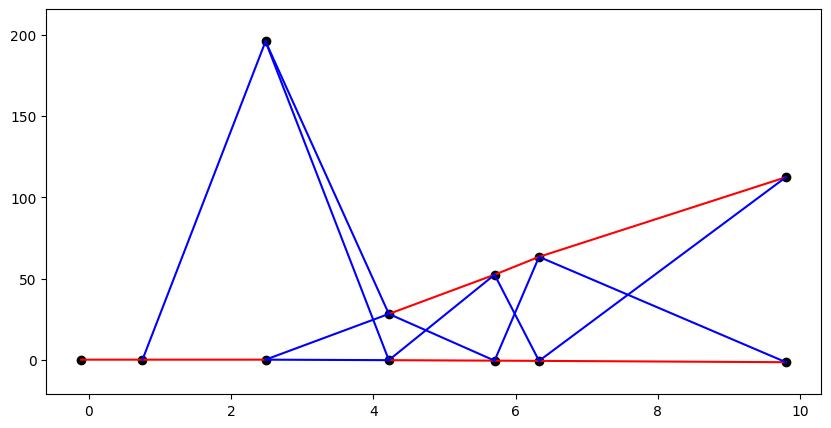

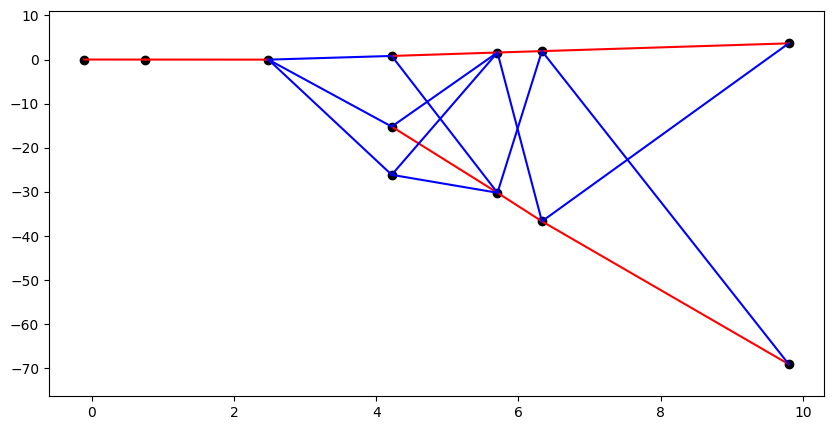

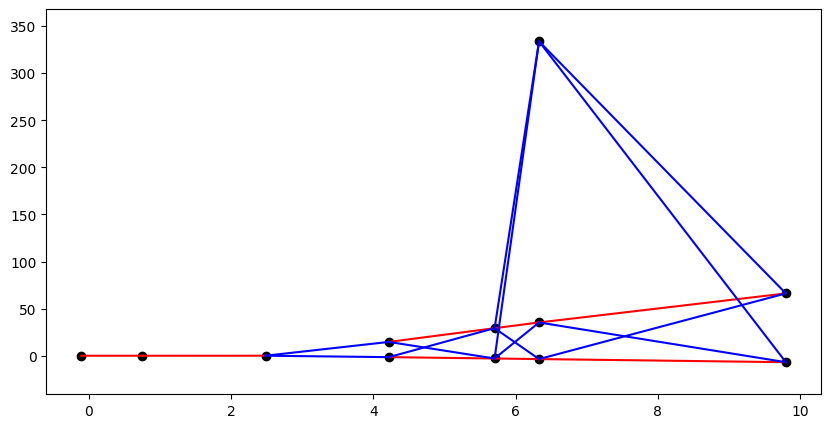

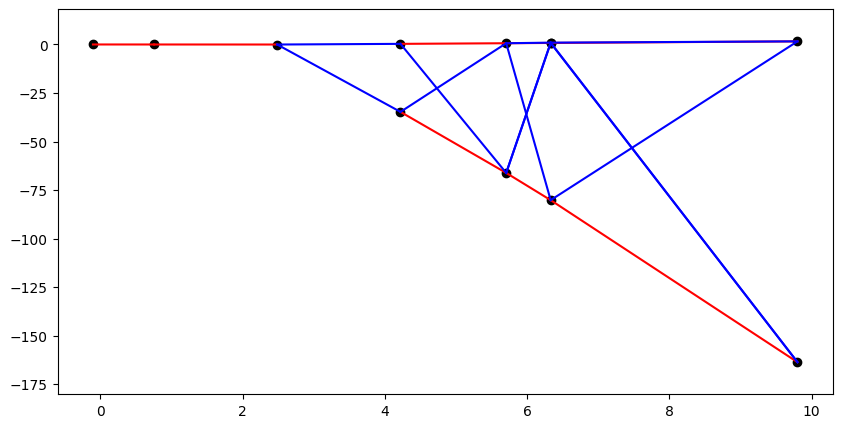

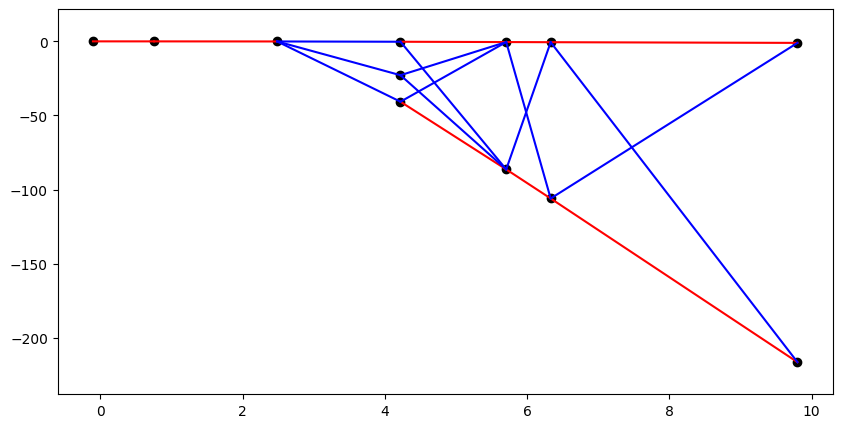

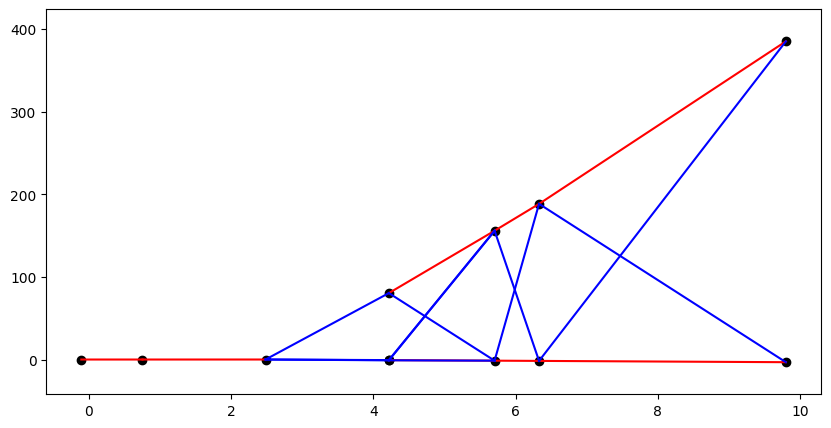

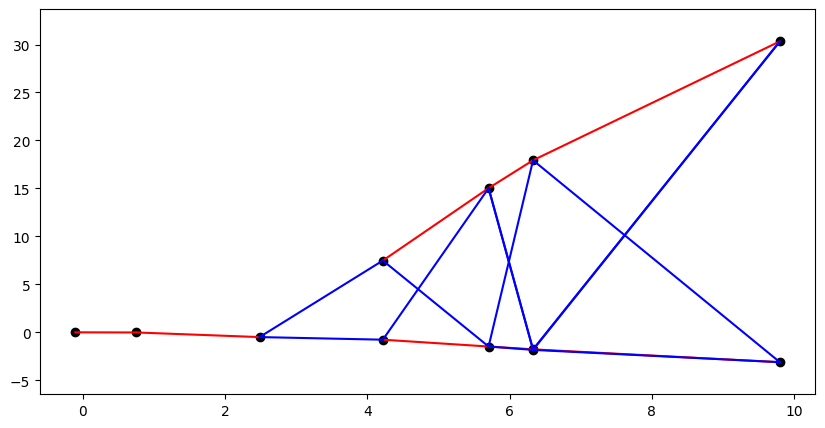

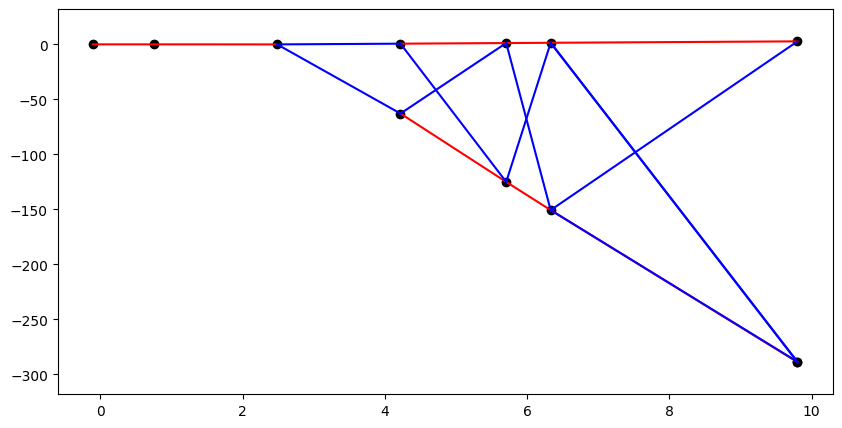

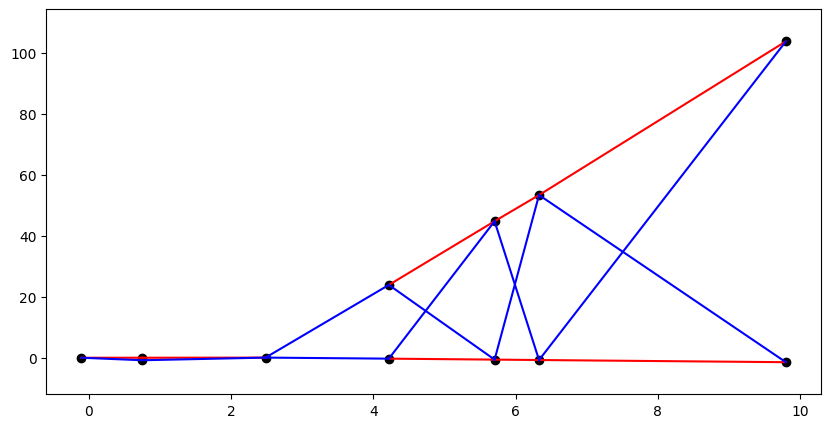

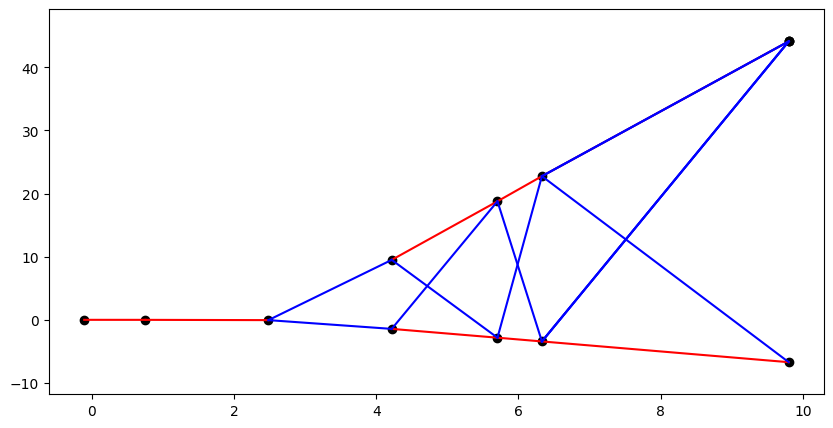

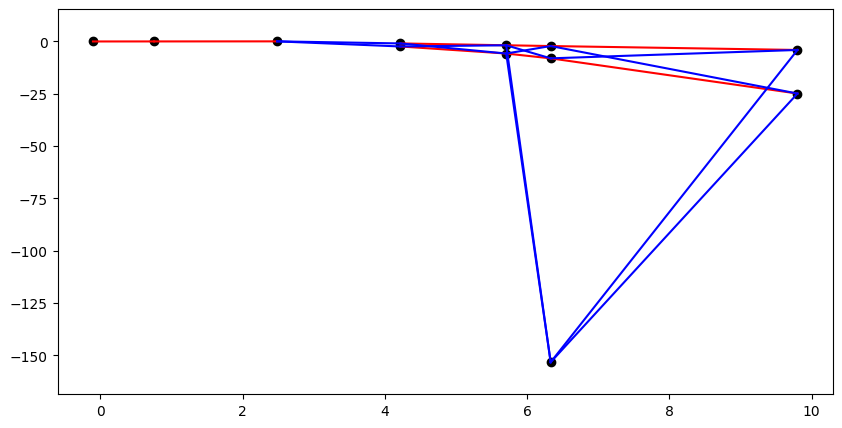

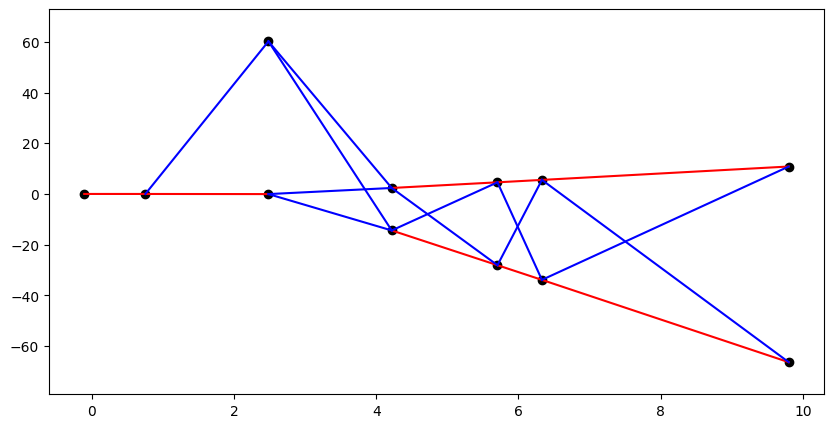

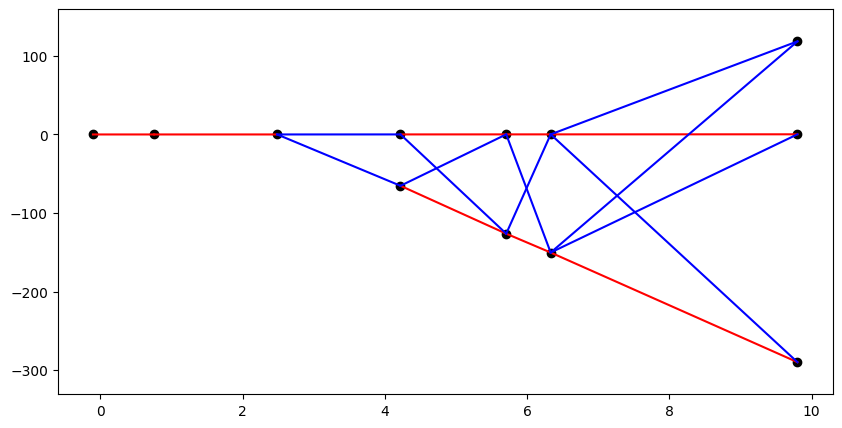

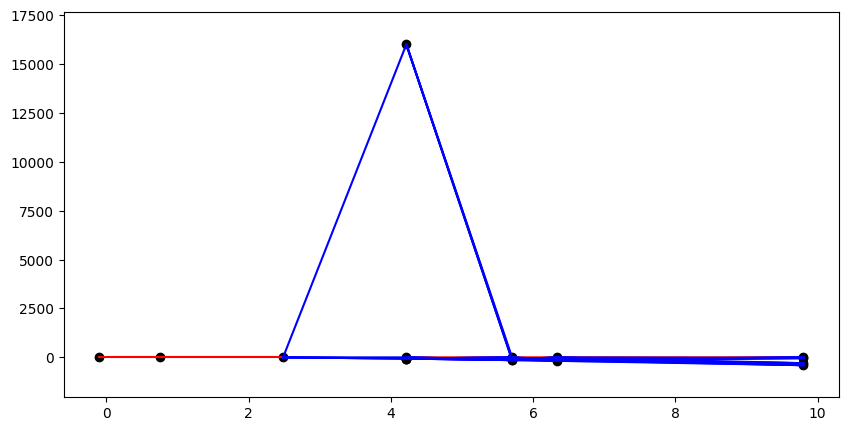

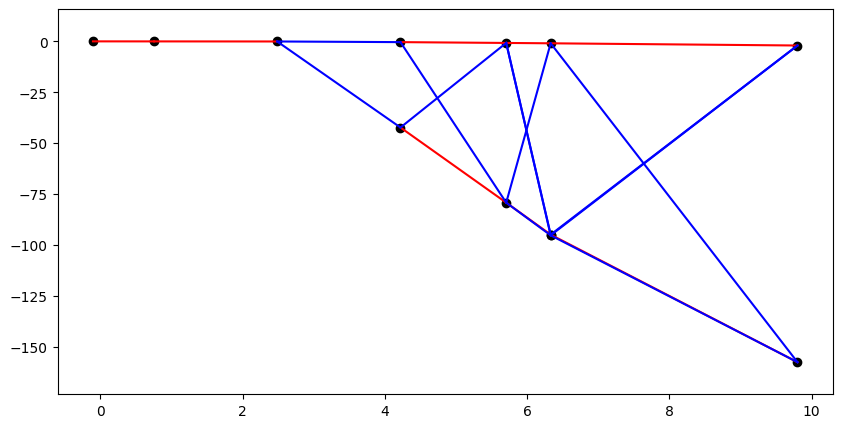

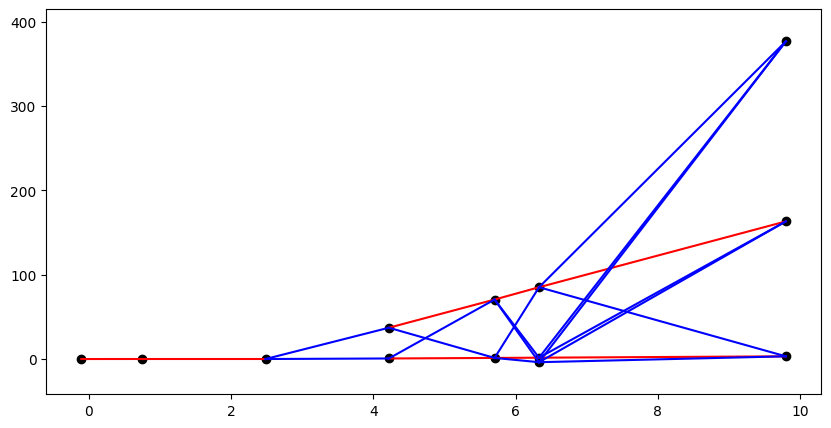

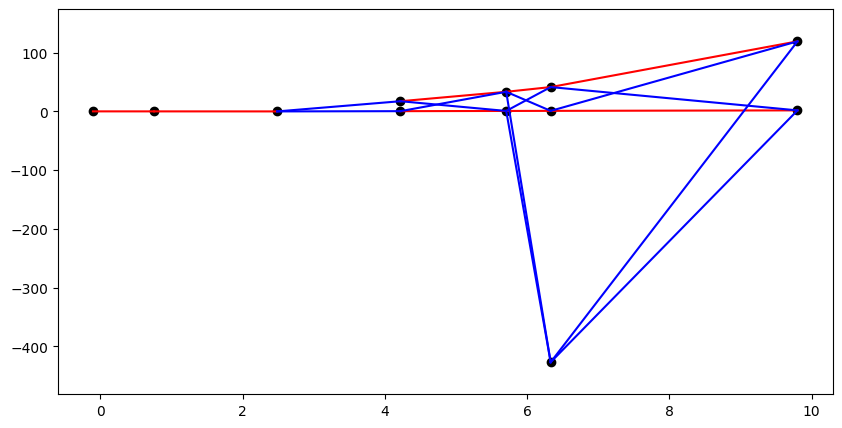

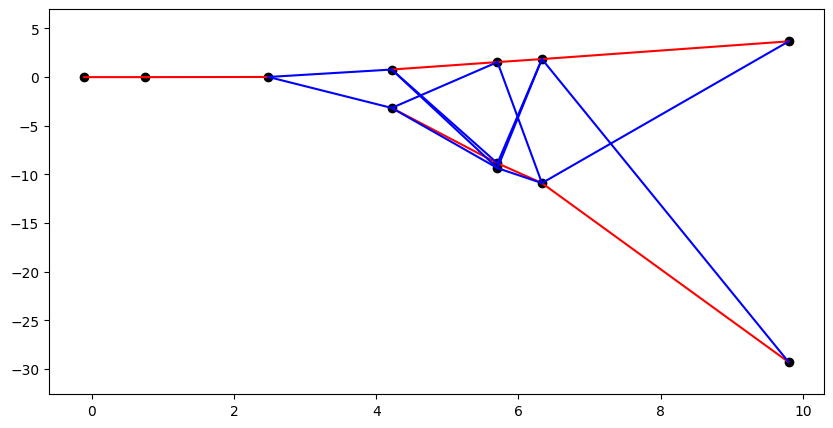

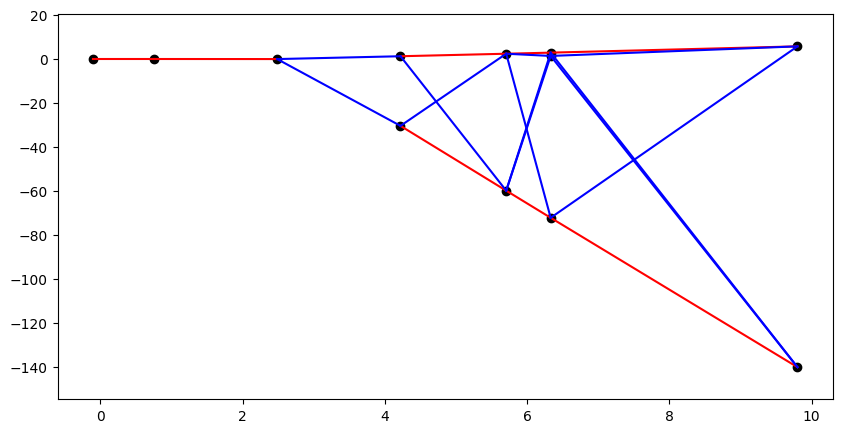

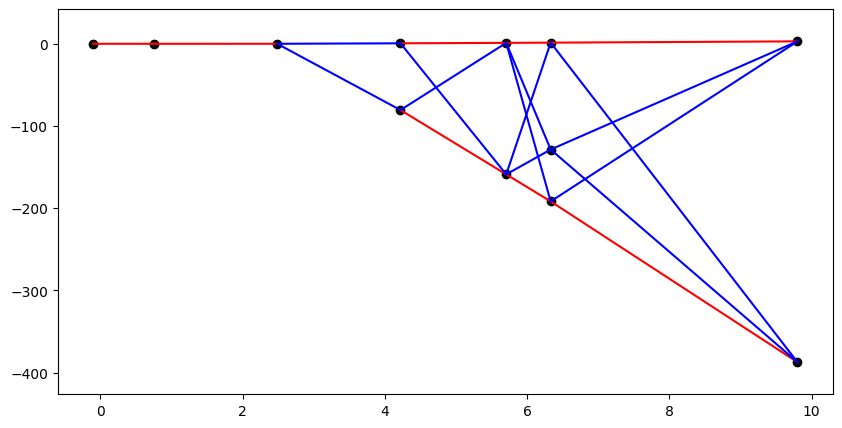

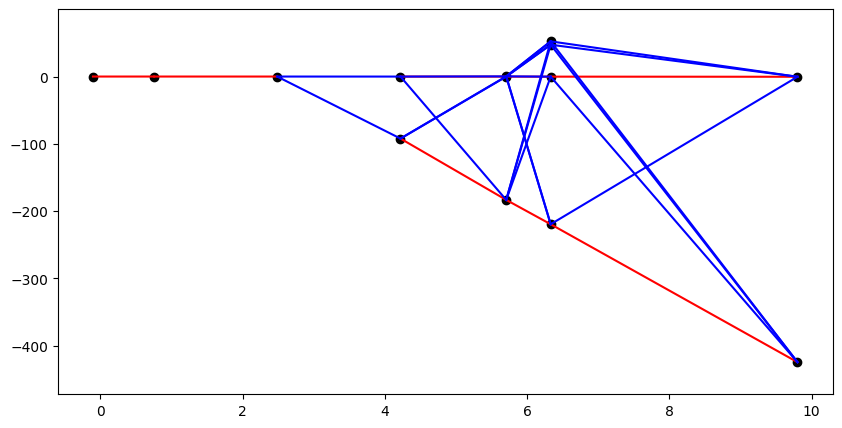

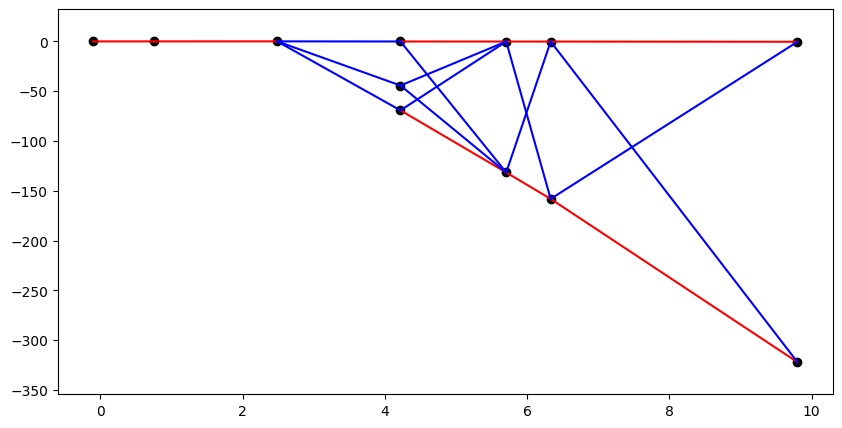

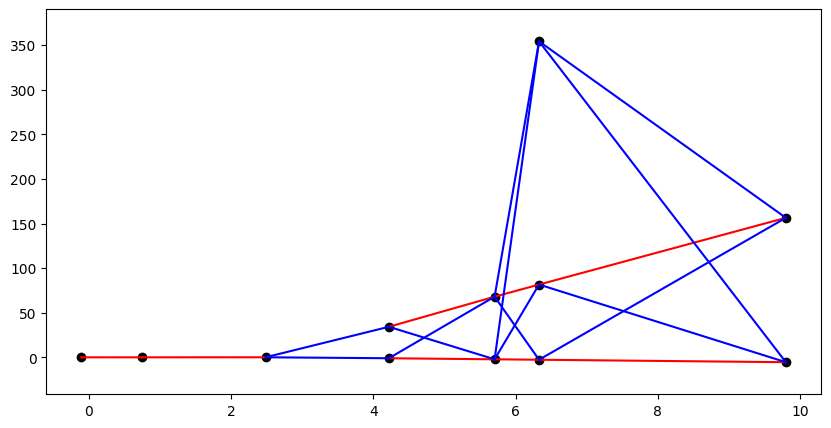

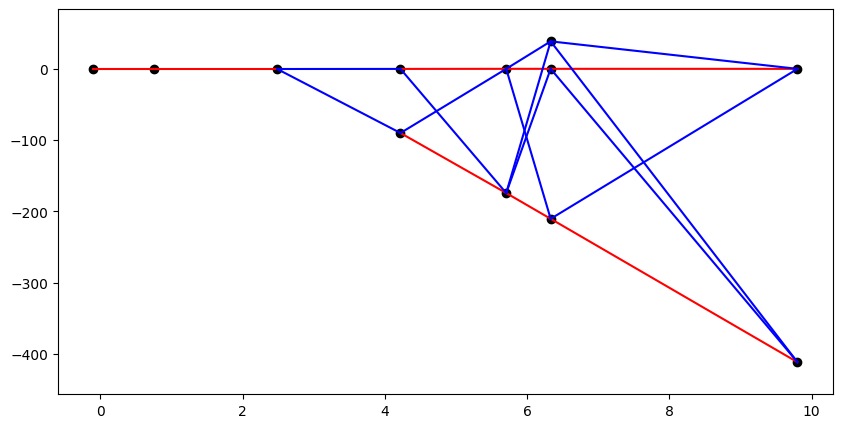

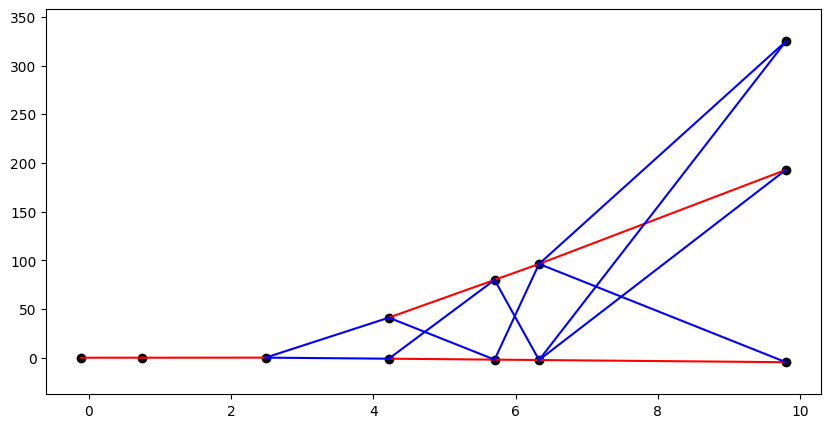

In [17]:
# Display few events
for k in range(200):
  #MWMW Plot some events with noisy hits
  if len(train_loader.dataset[k].y) > 16:
   print(len(data[data['nEvent'] == k]))
   plot_toy_graph(train_loader.dataset[k], 0.)

print(train_loader.dataset[k].x)

print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

print("Training dataset (events): ",len(train_dataset))
print("Test dataset (events): ",len(test_dataset))

In [18]:
print(train_dataset[0].x, train_dataset[0].nevent)

tensor([[-1.0500e-01,  6.7614e-08],
        [ 7.5500e-01,  3.5344e-03],
        [ 2.4850e+00, -3.8964e-03],
        [ 4.2185e+00,  8.9041e+01],
        [ 4.2185e+00, -4.4968e-02],
        [ 5.7050e+00,  1.7248e+02],
        [ 5.7050e+00, -6.1535e-02],
        [ 6.3300e+00,  2.1007e+02],
        [ 6.3300e+00, -7.4073e-02],
        [ 9.8000e+00,  4.1649e+02],
        [ 9.8000e+00, -1.7346e-01]]) 9255


In [19]:
weight = ((len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("True / Fake = ", 1/weight)
print("Fake / True = ", weight)

True / Fake =  1.0
Fake / True =  1.0


In [20]:
# Actual training. The number of epochs is set to 150 to give a chance
# to recognize noisy hits

t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = 1

#device = torch.device('cpu')

#normalize_factor = 1 -> see norm_factor definition
m_configs = {'normalize_factor': 1 ,"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

#m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
#model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad=True)

for epoch in range(150):
    ep += 1  
    model.train()
    acc_t, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc_t)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)
    # For printout: both training and validation accuracy added
    if ep % 10 == 1 or True :
      print('Epoch: {}, Accuracy train: {:.4f} valid: {:.4f}'.format(ep, acc_t, acc))


Epoch: 1, Accuracy train: 0.7688 valid: 0.9380
Epoch: 2, Accuracy train: 0.9618 valid: 0.9755
Epoch: 3, Accuracy train: 0.9800 valid: 0.9785
Epoch: 4, Accuracy train: 0.9827 valid: 0.9806
Epoch: 5, Accuracy train: 0.9841 valid: 0.9809
Epoch: 6, Accuracy train: 0.9851 valid: 0.9825
Epoch: 7, Accuracy train: 0.9861 valid: 0.9843
Epoch: 8, Accuracy train: 0.9868 valid: 0.9851
Epoch: 9, Accuracy train: 0.9871 valid: 0.9847
Epoch: 10, Accuracy train: 0.9874 valid: 0.9851
Epoch: 11, Accuracy train: 0.9878 valid: 0.9856
Epoch: 12, Accuracy train: 0.9879 valid: 0.9859
Epoch: 13, Accuracy train: 0.9880 valid: 0.9860
Epoch: 14, Accuracy train: 0.9881 valid: 0.9861
Epoch: 15, Accuracy train: 0.9883 valid: 0.9866
Epoch: 16, Accuracy train: 0.9886 valid: 0.9863
Epoch: 17, Accuracy train: 0.9884 valid: 0.9861
Epoch: 18, Accuracy train: 0.9887 valid: 0.9871
Epoch: 19, Accuracy train: 0.9888 valid: 0.9870
Epoch: 20, Accuracy train: 0.9891 valid: 0.9870
Epoch: 21, Accuracy train: 0.9891 valid: 0.9868
E

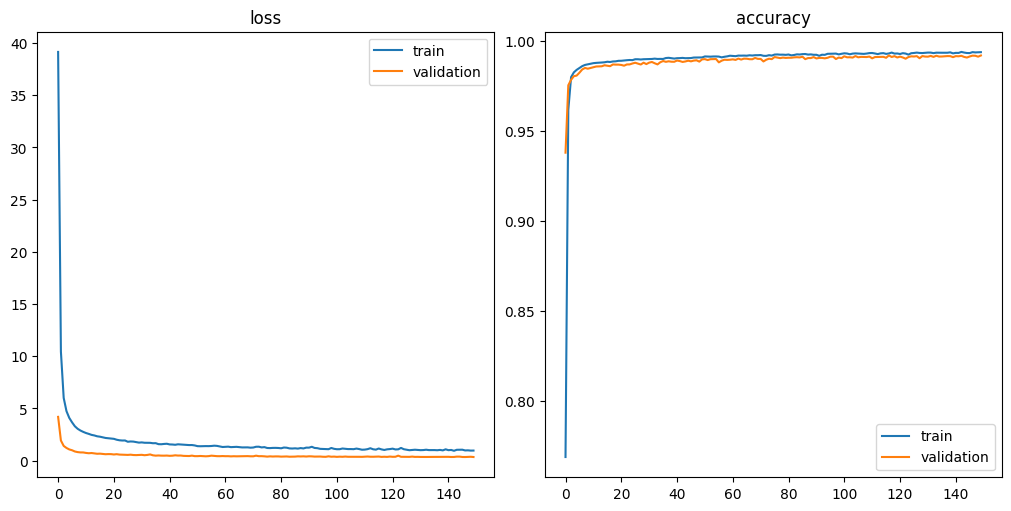

In [21]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].set_title("loss")
axs[0].set_yscale("linear")
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, label='train')
axs[0].plot(np.arange(len(v_loss_v)), v_loss_v, label='validation')
axs[0].legend()

axs[1].set_title("accuracy")
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, label='train')
axs[1].plot(np.arange(len(v_acc_v)), v_acc_v, label='validation')
axs[1].legend()
axs[1].set_yscale("linear")

In [22]:
def plot_toy_classified(event, preds, cut=0.5):
    
    #print("New event")
        
    #print(event)
    #print(event.x)
    #print(event.pid)
    #print(event.y)
    #gprint(preds)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    plt.title(event.nevent)
    preds = preds.detach().numpy()
    

    for j in range(len(labels)):
        
        #print(str('%01.2f' % preds[j])+" "+str(labels[j].item())+" "+str(x[edges[0,j]]*feature_scale)+","+str(y[edges[0,j]]*feature_scale)+" "+str(x[edges[1,j]]*feature_scale)+","+str(y[edges[1,j]]*feature_scale))
        s = str('%01.2f' % preds[j])+" "+str(labels[j].item())
        plt.text((x[edges[0,j]]+x[edges[1,j]])/2., (y[edges[0,j]]+y[edges[1,j]])/2.+np.random.random(1)*0.00, s, fontsize=12)

        # False negatives   dashed blue
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives  dashed RED
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='r', alpha=preds[j])

        # True positives   BLACK
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives  BLACK
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
            
         # True edges from simulation ORANGE
        if labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     linestyle='solid', c='orange',  lw=7, alpha=0.3)
            
           

In [23]:
def full_acc(test_loader):
  corr = 0
  for k in range(len(test_loader.dataset)):
    data = test_loader.dataset[k].to(device)
    preds = torch.sigmoid(model(data)).to('cpu')
    cut = 0.6
    corr += int(np.array_equal(preds.detach().numpy() > cut,data.to('cpu').y.detach().numpy()))
  return(corr/len(test_loader.dataset))

In [24]:
full_acc(test_loader)

0.9265

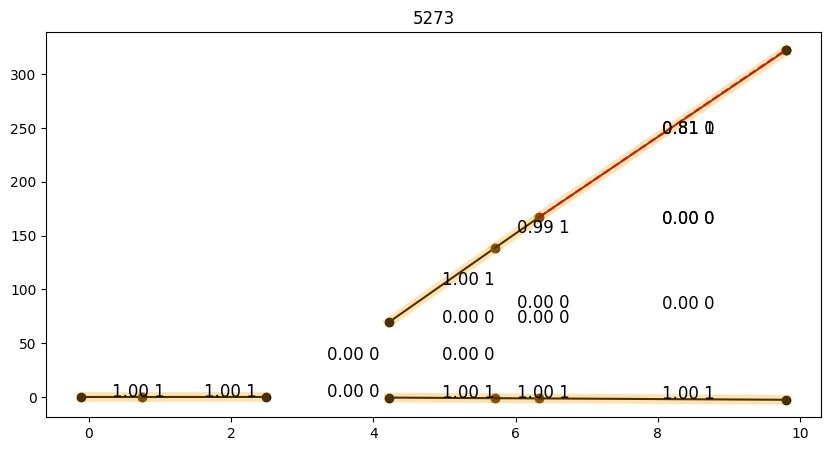

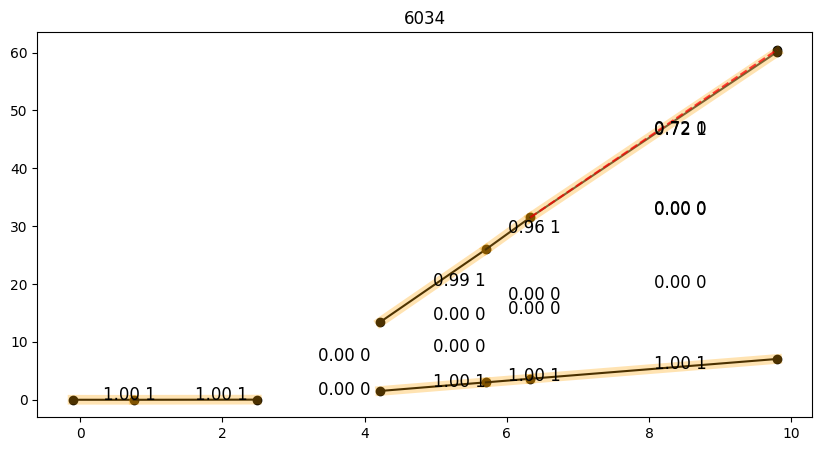

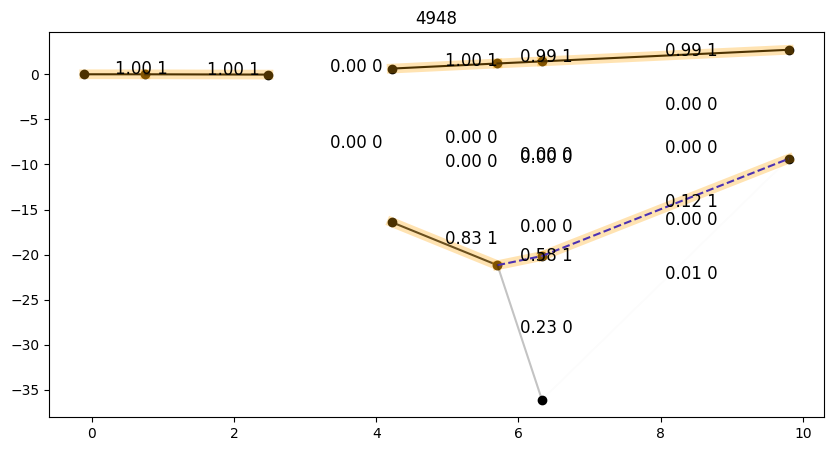

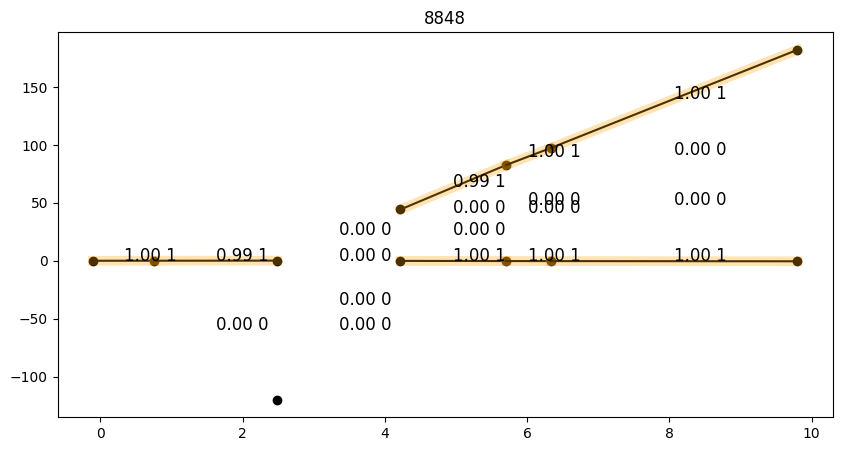

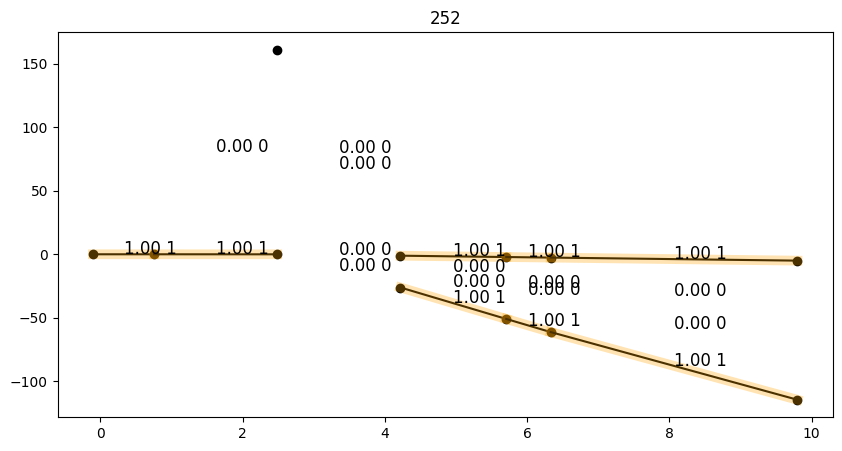

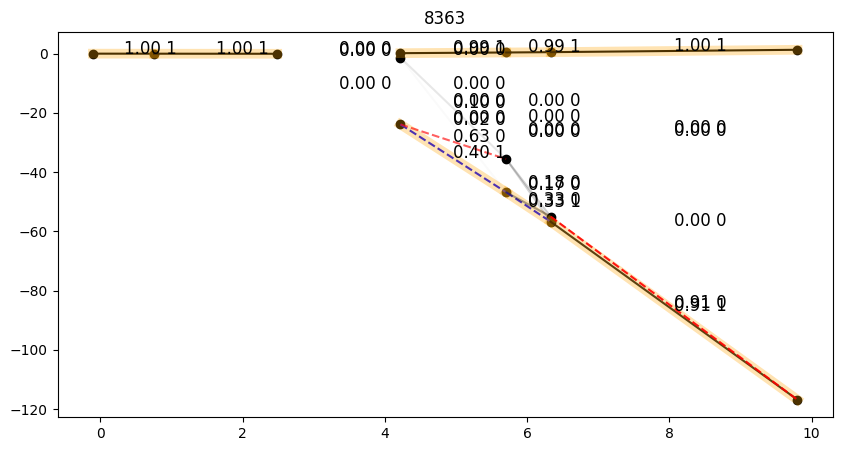

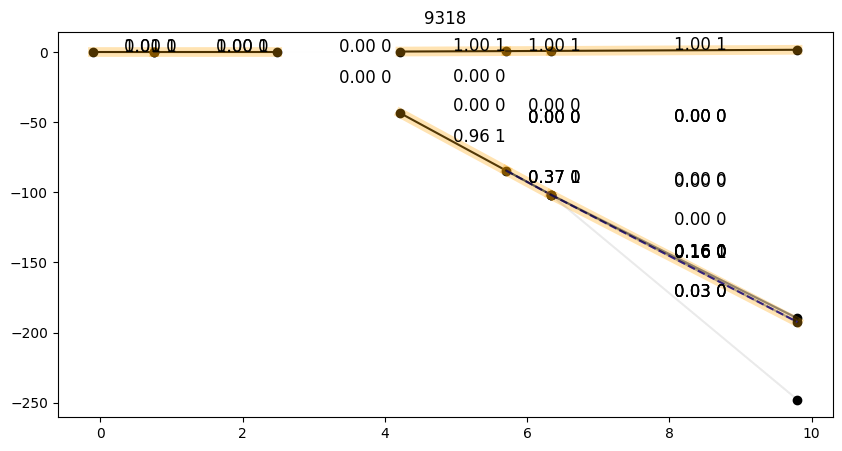

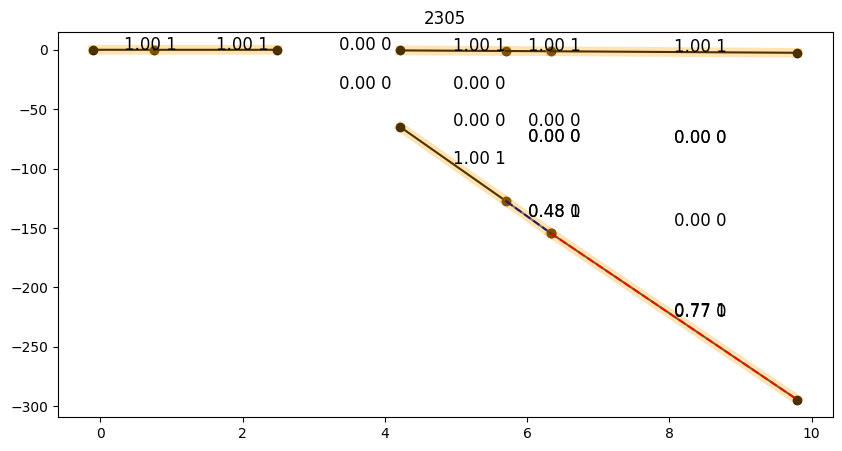

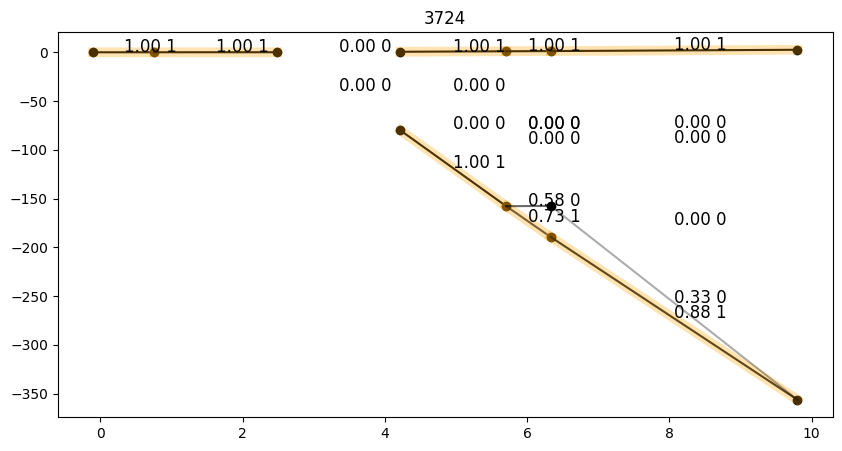

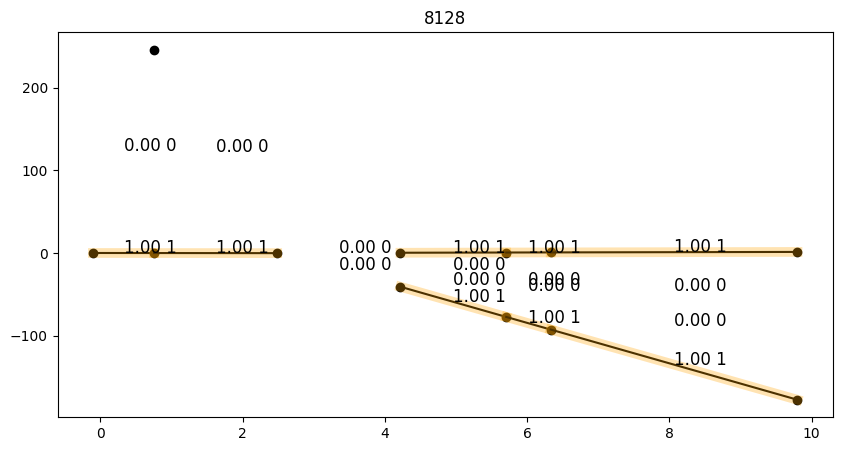

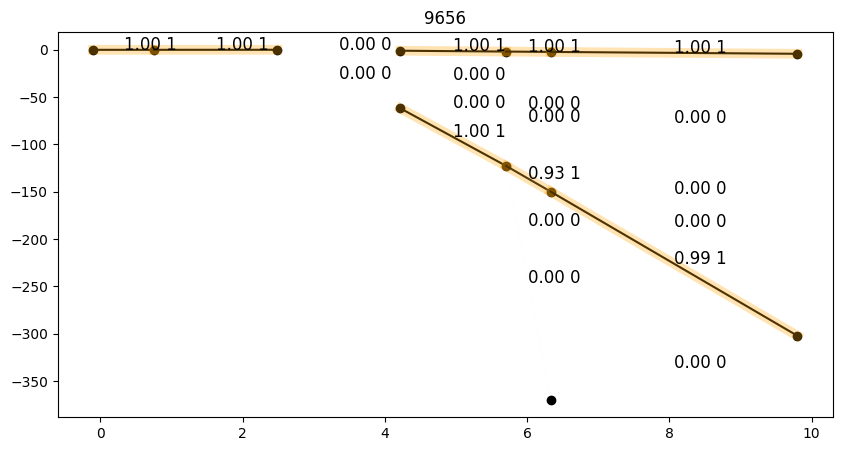

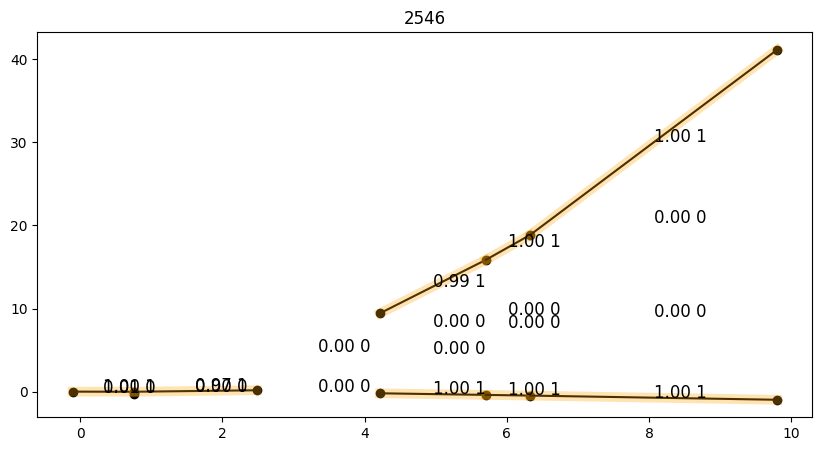

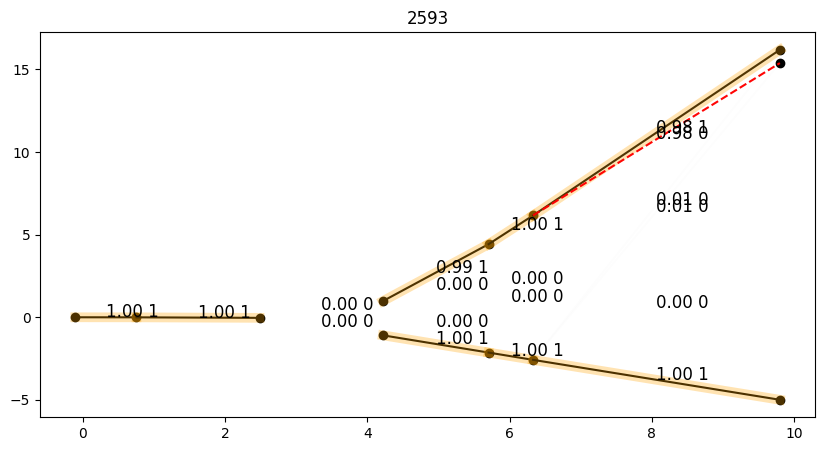

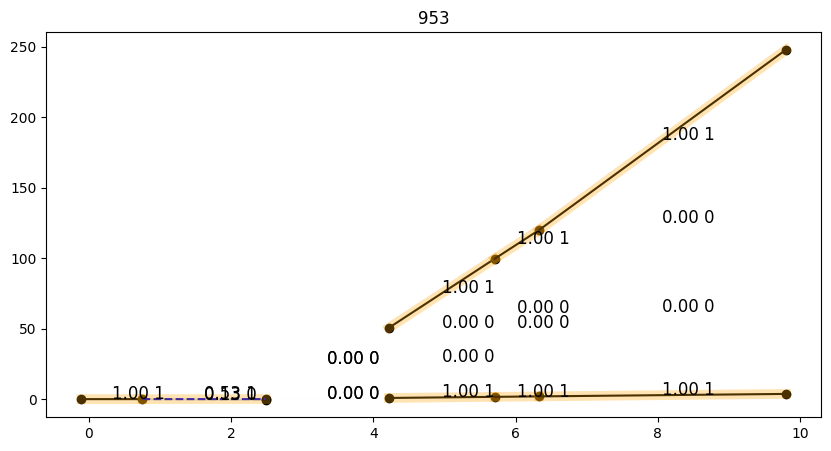

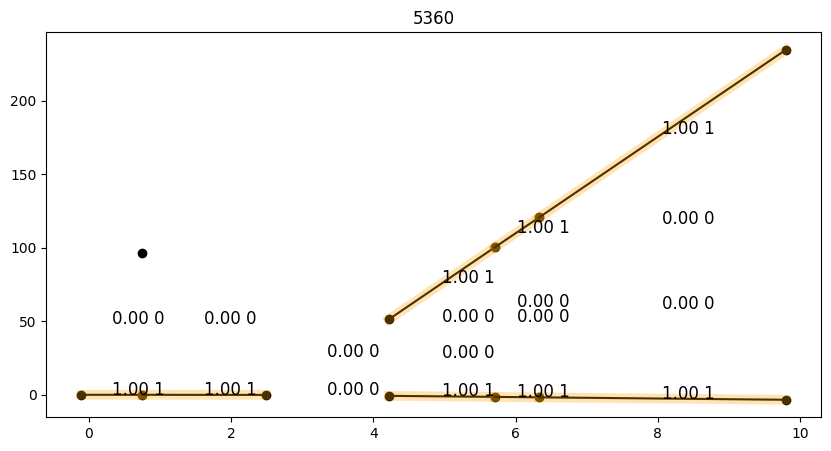

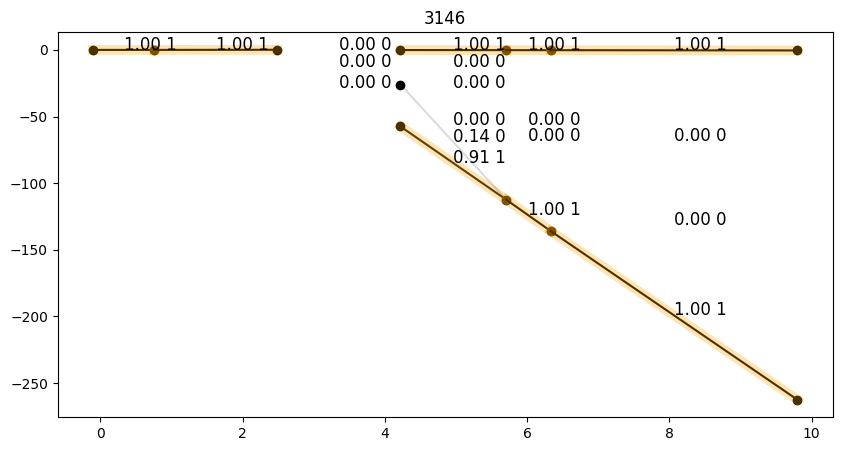

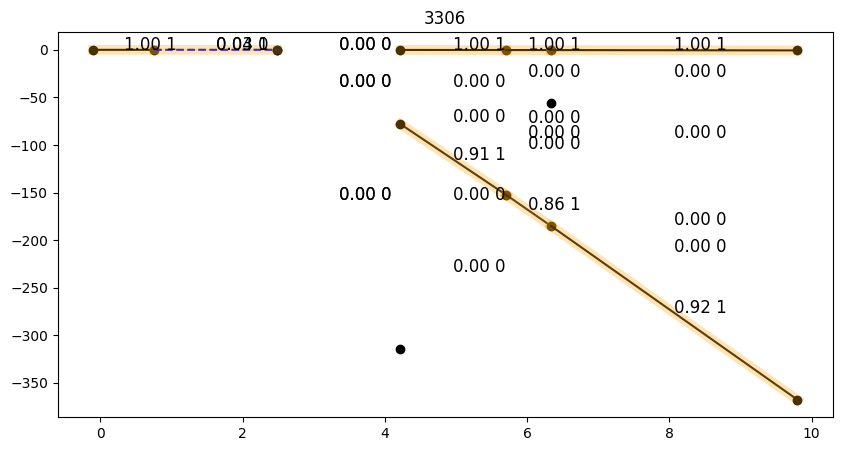

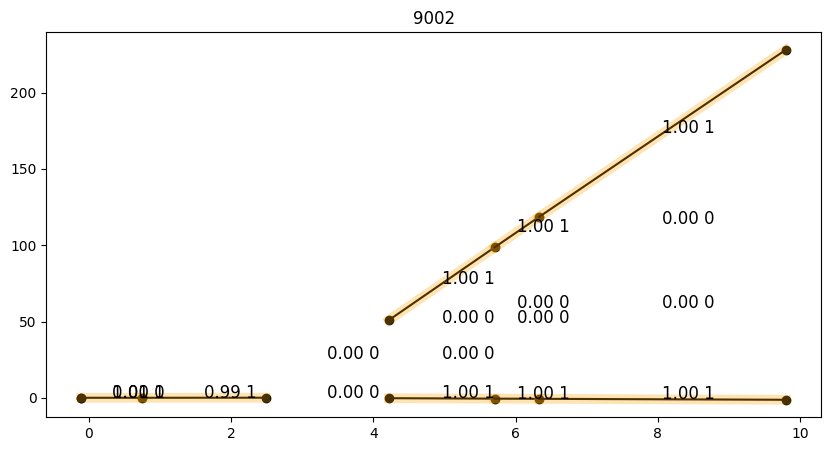

In [25]:
#MWMW Plot some events WITH noisy hits
# Orange line shows the true edges

for k in range(100):
   data = test_loader.dataset[k].to(device)
   preds = torch.sigmoid(model(data)).to('cpu')
   cut = 0.6
   #MWMW if not np.array_equal(preds.detach().numpy() > cut,data.to('cpu').y.detach().numpy()) or k == 0:
   if len(data.to('cpu').y)>16: 
     plot_toy_classified(data.to('cpu'), preds, cut = cut)

Lets try to increase the % of dirty events in the train datasen

In [26]:
from sklearn.utils import shuffle
total = 0
clean = 0
dirty = 0
clean_idx = []
dirty_idx = []
train_dataset = shuffle(train_datasetx + train_datasety, random_state=42)
for i,data in enumerate(train_dataset):
  total += 1
  if len(data.y) == 16:
    clean += 1
    clean_idx.append(i)
  else:
    dirty += 1
    dirty_idx.append(i)

In [27]:
print(clean/total)
print(dirty/total)


0.8438125
0.1561875


In [28]:
p = dirty/clean
p=p*0.25
new_clean_idx = shuffle(clean_idx)[:int(p*len(clean_idx))]

In [29]:
new_data = shuffle([train_dataset[i] for i in dirty_idx+new_clean_idx], random_state=42)
new_train, new_test = train_test_split(new_data, test_size=0.2, random_state=42)
ntrain_loader = DataLoader(new_train, batch_size=100, shuffle=True)
ntest_loader = DataLoader(new_test, batch_size=100, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [30]:
total = 0
clean = 0
dirty = 0
for i,data in enumerate(new_train):
  total += 1
  if len(data.y) == 16:
    clean += 1
  else:
    dirty += 1
print(clean/total)
print(dirty/total)

0.20296236989591673
0.7970376301040832


In [31]:
print(new_data[1])

Data(x=[11, 2], edge_index=[2, 16], y=[16], nevent=6767)


In [ ]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = 1

#device = torch.device('cpu')

#normalize_factor = 1 -> see norm_factor definition
m_configs = {'normalize_factor': 1 ,"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

#m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
#model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad=True)

for epoch in range(12):
    ep += 1  
    model.train()
    acc_t, total_loss = train(model, ntrain_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc_t)

    model.eval()
    acc, total_loss = evaluate(model, ntest_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)
    if ep % 10 == 1 or True :
      print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc,acc_t))


Epoch: 1, Accuracy: 0.8187
Epoch: 2, Accuracy: 0.8696
Epoch: 3, Accuracy: 0.9171
Epoch: 4, Accuracy: 0.9333
Epoch: 5, Accuracy: 0.9398
Epoch: 6, Accuracy: 0.9406
Epoch: 7, Accuracy: 0.9468
Epoch: 8, Accuracy: 0.9456
Epoch: 9, Accuracy: 0.9482
Epoch: 10, Accuracy: 0.9490
Epoch: 11, Accuracy: 0.9491


In [ ]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].set_title("loss")
axs[0].set_yscale("linear")
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, label='train')
axs[0].plot(np.arange(len(v_loss_v)), v_loss_v, label='validation')
axs[0].legend()

axs[1].set_title("accuracy")
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, label='train')
axs[1].plot(np.arange(len(v_acc_v)), v_acc_v, label='validation')
axs[1].legend()
axs[1].set_yscale("linear")

In [ ]:
full_acc(ntest_loader)

In [ ]:
full_acc(test_loader)

In [ ]:
for k in range(100):
   data = ntest_loader.dataset[k].to(device)
   preds = torch.sigmoid(model(data)).to('cpu')
   cut = 0.6
   if not np.array_equal(preds.detach().numpy() > cut,data.to('cpu').y.detach().numpy()) or k == 0:
     plot_toy_classified(data.to('cpu'), preds, cut = cut)